Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data
License(s): CC0-1.0
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 10.3MB/s]
Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  
Mean Squared Error: 5.5568219896639945
R-squared Score: 0.8929804668742881


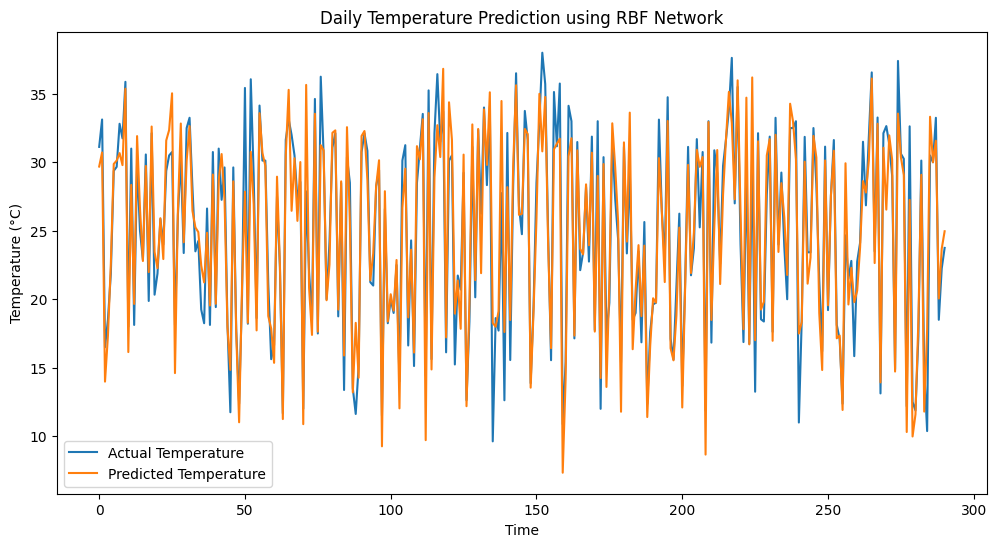

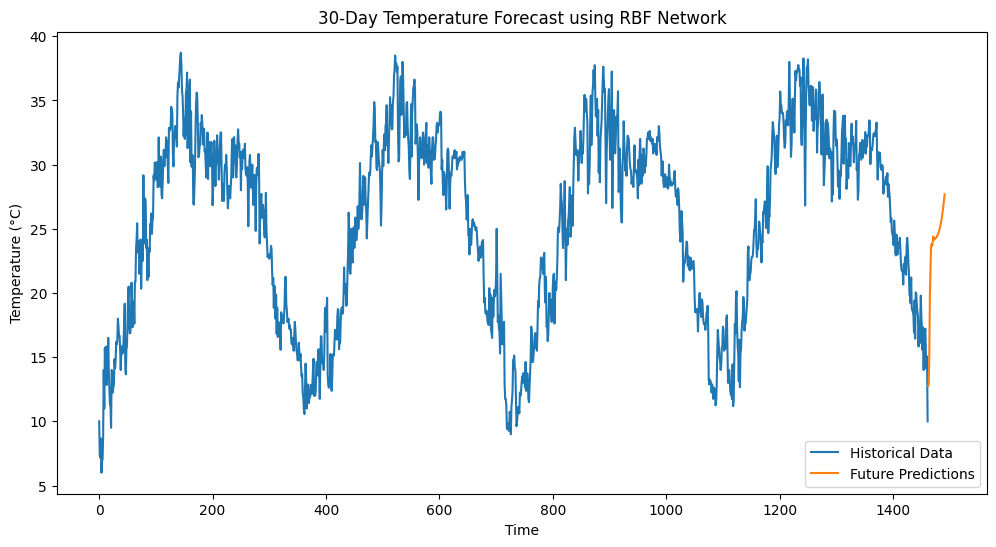

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Download the dataset from Kaggle
# You need to have kaggle API set up on your machine
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
!unzip daily-climate-time-series-data.zip

# Load the dataset
df = pd.read_csv('DailyDelhiClimateTrain.csv')

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values('date')

# We'll use 'meantemp' as our target variable
temperature_data = df['meantemp'].values

class RBFNetwork:
    def __init__(self, n_centers, sigma=1.0):
        self.n_centers = n_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _gaussian_rbf(self, x, c):
        return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * self.sigma**2))

    def fit(self, X, y):
        # Randomly select centers
        center_indices = np.random.choice(X.shape[0], self.n_centers, replace=False)
        self.centers = X[center_indices]

        # Calculate RBF activations
        G = np.zeros((X.shape[0], self.n_centers))
        for i, center in enumerate(self.centers):
            G[:, i] = self._gaussian_rbf(X, center)

        # Add bias term
        G = np.column_stack([G, np.ones(X.shape[0])])

        # Calculate weights using pseudo-inverse
        self.weights = np.linalg.pinv(G) @ y

    def predict(self, X):
        G = np.zeros((X.shape[0], self.n_centers))
        for i, center in enumerate(self.centers):
            G[:, i] = self._gaussian_rbf(X, center)
        G = np.column_stack([G, np.ones(X.shape[0])])
        return G @ self.weights

def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Prepare the data
look_back = 7  # Use the last 7 days to predict the next day's temperature
X, y = create_dataset(temperature_data, look_back)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, look_back))
X_test_scaled = scaler.transform(X_test.reshape(-1, look_back))

# Train the RBF Network
rbf_temp = RBFNetwork(n_centers=100, sigma=0.5)
rbf_temp.fit(X_train_scaled, y_train)

# Make predictions
predictions_temp = rbf_temp.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions_temp)
r2 = r2_score(y_test, predictions_temp)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Temperature')
plt.plot(predictions_temp, label='Predicted Temperature')
plt.title('Daily Temperature Prediction using RBF Network')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Predict the next 30 days
last_sequence = temperature_data[-look_back:]
future_predictions = []

for _ in range(30):
    scaled_sequence = scaler.transform(last_sequence.reshape(1, -1))
    next_pred = rbf_temp.predict(scaled_sequence)[0]
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(temperature_data)), temperature_data, label='Historical Data')
plt.plot(range(len(temperature_data), len(temperature_data) + 30), future_predictions, label='Future Predictions')
plt.title('30-Day Temperature Forecast using RBF Network')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()